In [1]:
import nltk
import re
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sqlalchemy import create_engine

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

In [3]:
def tokenize(text):
    '''
    Create tokens and then lemmatize the tokens. Useful for including in CountVectorizer
    Parameters:
        text (str): Input text to be tokenized
    '''
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = []
    for tok in tokens:
        clean_token = lemmatizer.lemmatize(tok).lower().strip()
        lemmatized_tokens.append(clean_token)
    return lemmatized_tokens

In [5]:
def evaluate_model(trained_model, X_test, y_test, y_pred, column_labels, category_subset):
    '''
    Calculate accuracy, precision, recall and f1 score for the input model
    Parameters:
        trained_model: Model to be used for prediction on the test dataset
        X_test: Input for the prediction
        y_test: Ground truth or the correct prediction
        y_pred: Predicted results
        column_labels: Labels for the predicted variables
    Returns:
        trained_model_accuracy: Overall accuracy of the trained model
        accuracy_df: Dataframe containing the performance metrics on the test set
    '''
    test_result_df = pd.DataFrame(y_test, columns = column_labels)
    pred_result_df = pd.DataFrame(y_pred, columns = column_labels)
    #column = 'related'
    #accuracy = accuracy_score(test_result_df['related'], pred_result_df['related'])
    trained_model_accuracy = trained_model.score(X_test, y_test)
    accuracy_df = pd.DataFrame(data = [], columns = ['Category', 'Accuracy','Precision', 'Recall', 'F1', 'Support', 'Balanced'])
    i = 0
    for column_name in column_labels:
        accuracy_score_column = round(accuracy_score(test_result_df[column_name], pred_result_df[column_name]), 2)
        precision_score_column = round(precision_score(test_result_df[column_name], pred_result_df[column_name]), 2)
        recall_score_column = round(recall_score(test_result_df[column_name], pred_result_df[column_name]), 2)
        f1_score_column = round(f1_score(test_result_df[column_name], pred_result_df[column_name]), 2)
        #print(column_name, '----', accuracy_score_column)
        if column_name in category_subset:
            balanced = True
        else:
            balanced = False
        accuracy_df.loc[i] = [column_name, accuracy_score_column, precision_score_column, recall_score_column, f1_score_column, 0, balanced]
        i += 1
    return accuracy_df, trained_model_accuracy

##### Step 1: 
##### Read the message/category dataset from the Sqlite database #####
##### Check for data imbalance #####
##### Set output features to the right format #####
##### Split the dataset into training and test set #####

In [6]:
db_engine = create_engine('sqlite:////home/prasannaiyer/Projects/NLP_Project/Data/DisasterResponse.db')
msg_df = pd.read_sql_table('Message_Category', db_engine)

##### Compute the proportion of each category in the overall dataset #####
##### This will show us if the dataset is imbalanced for certain categories #####

In [7]:
round(msg_df[msg_df.columns[~msg_df.columns.isin(['id', 'genre', 'message', 'original'])]].\
    sum()/msg_df[msg_df.columns[~msg_df.columns.isin(['id', 'genre', 'message', 'original'])]].count(),2)

related                   0.77
request                   0.17
offer                     0.00
aid_related               0.41
medical_help              0.08
medical_products          0.05
search_and_rescue         0.03
security                  0.02
military                  0.03
child_alone               0.00
water                     0.06
food                      0.11
shelter                   0.09
clothing                  0.02
money                     0.02
missing_people            0.01
refugees                  0.03
death                     0.05
other_aid                 0.13
infrastructure_related    0.07
transport                 0.05
buildings                 0.05
electricity               0.02
tools                     0.01
hospitals                 0.01
shops                     0.00
aid_centers               0.01
other_infrastructure      0.04
weather_related           0.28
floods                    0.08
storm                     0.09
fire                      0.01
earthqua

In [8]:
category_balance_df = pd.DataFrame((round(msg_df[msg_df.columns[~msg_df.columns.isin(['id', 'genre', 'message', 'original'])]].\
    sum()/msg_df[msg_df.columns[~msg_df.columns.isin(['id', 'genre', 'message', 'original'])]].count(),2).sort_values(ascending = False)>0.1),\
        columns = ['Balance']).reset_index()

In [9]:
category_balance_df.columns = ['Category', 'Balance']

In [10]:
#category_balance_df = category_balance_df.rename({'index':'Category', 'Balance': 'Balance'})
category_subset_balanced = category_balance_df[category_balance_df['Balance']==True]['Category'].values
category_subset_unbalanced = category_balance_df[category_balance_df['Balance']==False]['Category'].values

#### Change the format of the output features to Int ####

In [11]:
columnn_labels = msg_df.columns[~msg_df.columns.isin(['id', 'genre', 'message', 'original'])]

In [12]:
for column_name in msg_df.columns[~msg_df.columns.isin(['id', 'genre', 'message', 'original'])]:
    msg_df[column_name] = msg_df[column_name].astype('int')

##### Split the dataset into training and test set #####

In [13]:
X = msg_df['message'].values
y = msg_df.loc[:, ~msg_df.columns.isin(['id', 'genre', 'message', 'original'])].values
X_train, X_test, y_train, y_test = train_test_split(X, y)

##### Step 2: ##### 
##### Load the 2 trained models from the pickle files #####
##### Predict the output for the test set #####
##### Evaluate the model performance -- accuracy and classification report #####

In [14]:
pipeline_trained_model = pickle.load(open('/data2/home/prasannaiyer/Projects/NLP_Project/Code/pipeline_model.sav', 'rb'))
#pred_pipeline = pipeline_trained_model.predict(X_test)

In [15]:
pipeline_model_accuracy_df, pipeline_model_overall_acc = evaluate_model(\
    pipeline_trained_model, X_test, y_test, pred_pipeline, columnn_labels,category_subset_balanced)

/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/skl

In [14]:
#model_filename = open('/data2/home/prasannaiyer/Projects/NLP_Project/Code/cv_model.sav', 'rb')
cv_trained_model = pickle.load(open('/data2/home/prasannaiyer/Projects/NLP_Project/Code/cv_model.sav', 'rb'))
#pred_cv = cv_trained_model.predict(X_test)

In [15]:
cv_model_accuracy_df, cv_model_overall_acc = evaluate_model(cv_trained_model, X_test, y_test, pred_cv, columnn_labels, category_subset_balanced)

/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [26]:
cv_model_accuracy_df.head(35).sort_values(by = 'Balanced')

,Category,Accuracy,Precision,Recall,F1,Support,Balanced
17,death,0.99,1.00,0.76,0.86,0,False
32,earthquake,0.99,0.97,0.94,0.95,0,False
31,fire,1.00,1.00,0.70,0.82,0,False
30,storm,0.99,0.96,0.87,0.91,0,False
29,floods,0.98,0.99,0.82,0.90,0,False
27,other_infrastructure,0.99,1.00,0.77,0.87,0,False
26,aid_centers,1.00,1.00,0.73,0.84,0,False
25,shops,1.00,1.00,0.56,0.72,0,False
24,hospitals,1.00,1.00,0.70,0.83,0,False
23,tools,1.00,1.00,0.75,0.86,0,False


In [16]:
cv_model_accuracy_df[cv_model_accuracy_df['Balanced']==True]['Accuracy'].mean(), cv_model_accuracy_df[cv_model_accuracy_df['Balanced']==False]['Accuracy'].mean()

(0.9657142857142856, 0.992413793103448)

In [17]:
print('Accuracy: Pipeline = {:.2f}% and Gridsearch = {:.2f}%'.format(pipeline_model_overall_acc*100, cv_model_overall_acc*100))

Accuracy: Pipeline = 30.03% and Gridsearch = 80.62%


/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]),
 [Text(0, 0, 'related'),
  Text(1, 0, 'aid_related'),
  Text(2, 0, 'weather_related'),
  Text(3, 0, 'direct_report'),
  Text(4, 0, 'request'),
  Text(5, 0, 'other_aid'),
  Text(6, 0, 'food'),
  Text(7, 0, 'earthquake'),
  Text(8, 0, 'storm'),
  Text(9, 0, 'shelter'),
  Text(10, 0, 'floods'),
  Text(11, 0, 'medical_help'),
  Text(12, 0, 'infrastructure_related'),
  Text(13, 0, 'water'),
  Text(14, 0, 'other_weather'),
  Text(15, 0, 'buildings'),
  Text(16, 0, 'medical_products'),
  Text(17, 0, 'transport'),
  Text(18, 0, 'death'),
  Text(19, 0, 'other_infrastructure'),
  Text(20, 0, 'military'),
  Text(21, 0, 'refugees'),
  Text(22, 0, 'search_and_rescue'),
  Text(23, 0, 'money'),
  Text(24, 0, 'electricity'),
  Text(25, 0, 'cold'),
  Text(26, 0, 'clothing'),
  Text(27, 0, 'security'),
  Text(28, 0, 'fire'),
  Text(29, 

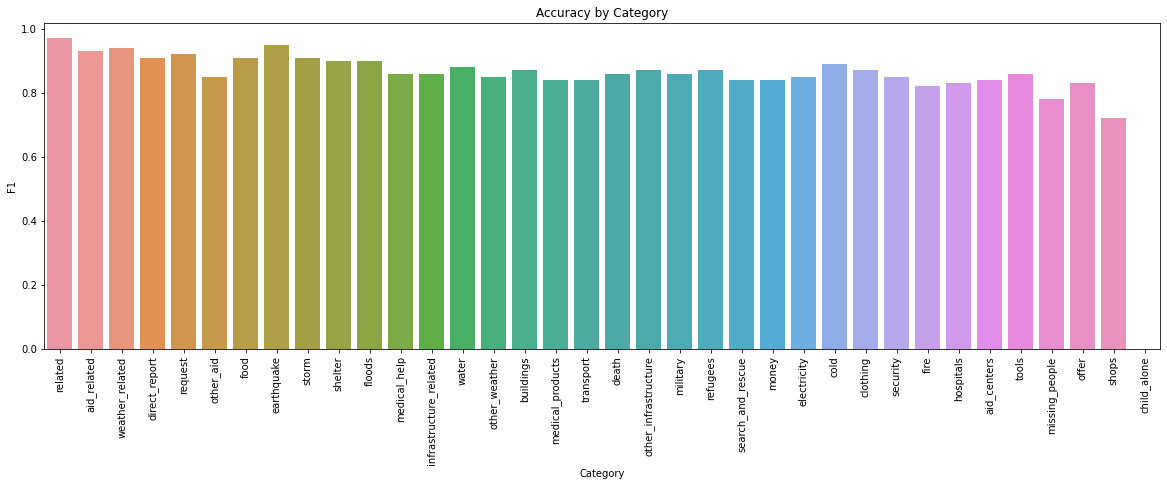

In [18]:
fig = plt.figure(figsize = (20, 6))
#ax = sns.barplot(cv_model_accuracy_df['Category'], cv_model_accuracy_df['F1'], hue = cv_model_accuracy_df['Balanced'], \
 #   order = np.append(category_subset_balanced, category_subset_unbalanced))
ax = sns.barplot(cv_model_accuracy_df['Category'], cv_model_accuracy_df['F1'], \
    order = np.append(category_subset_balanced, category_subset_unbalanced))
ax.set_title('Accuracy by Category')
plt.xticks(rotation=90)

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

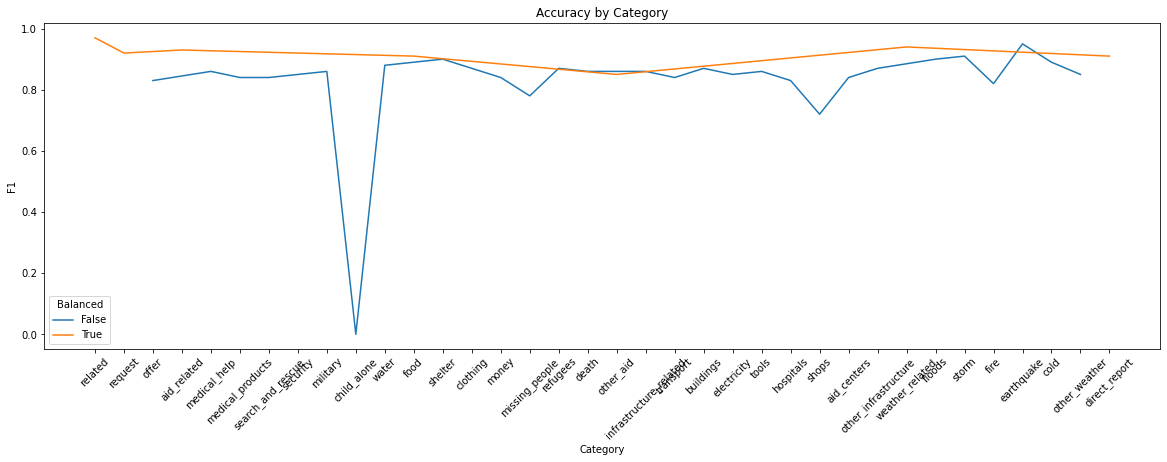

In [21]:
fig = plt.figure(figsize = (20, 6))
ax = sns.lineplot(x = cv_model_accuracy_df['Category'], y = cv_model_accuracy_df['F1'], hue = cv_model_accuracy_df['Balanced'])
ax.set_title('Accuracy by Category')
plt.xticks(rotation=45)

In [20]:
print(classification_report(y_test, pred_cv))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      5024
           1       0.98      0.87      0.92      1088
           2       1.00      0.71      0.83        31
           3       0.96      0.91      0.93      2721
           4       0.99      0.76      0.86       518
           5       0.99      0.73      0.84       301
           6       0.99      0.73      0.84       184
           7       1.00      0.73      0.85       120
           8       0.99      0.76      0.86       221
           9       0.00      0.00      0.00         0
          10       0.99      0.79      0.88       434
          11       0.99      0.84      0.91       736
          12       0.98      0.82      0.90       539
          13       0.99      0.77      0.87        97
          14       1.00      0.73      0.84       128
          15       1.00      0.63      0.78        82
          16       1.00      0.76      0.87       224
          17       1.00    

/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data2/prasannaiyer/envs/NLP_py335/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/da